#SVAR 기반 테슬라 주가 예측 코드 (Cholesky 분해 방식)

1. 제약 조건이 있는 SVAR 모델을 직접 구성  
statsmodels.tsa.api.VAR을 사용하여 일반적인 VAR 모델을 학습한 후 구조적 제약을 반영하여 변수를 조정하는 방식 적용

2. Cholesky 분해를 이용한 구조적 SVAR 근사  
 chol_decomp = np.linalg.cholesky(cov_matrix)  
 Cholesky 분해를 이용해 구조적 충격 반응을 분석할 수 있음

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ 최적의 차수 (p): 5
📌 Test MSE: 396.1479


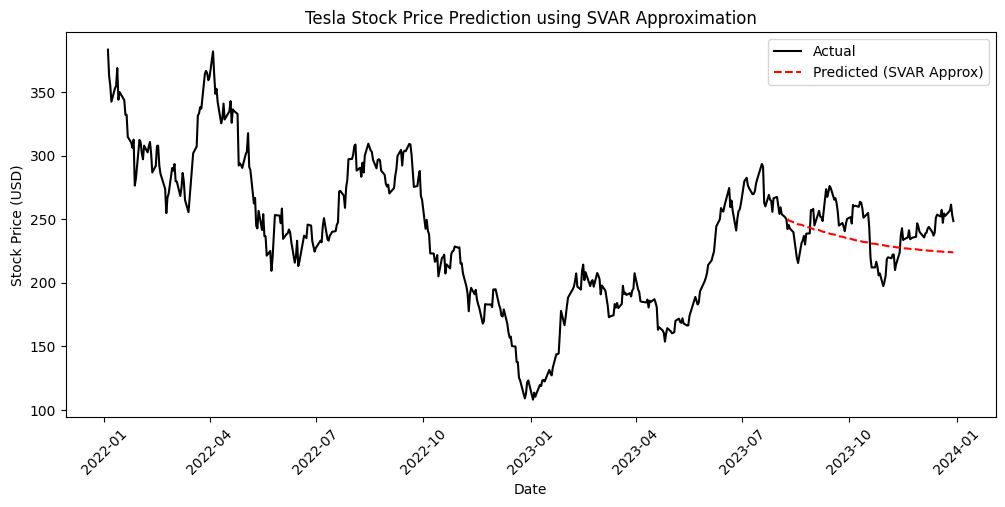

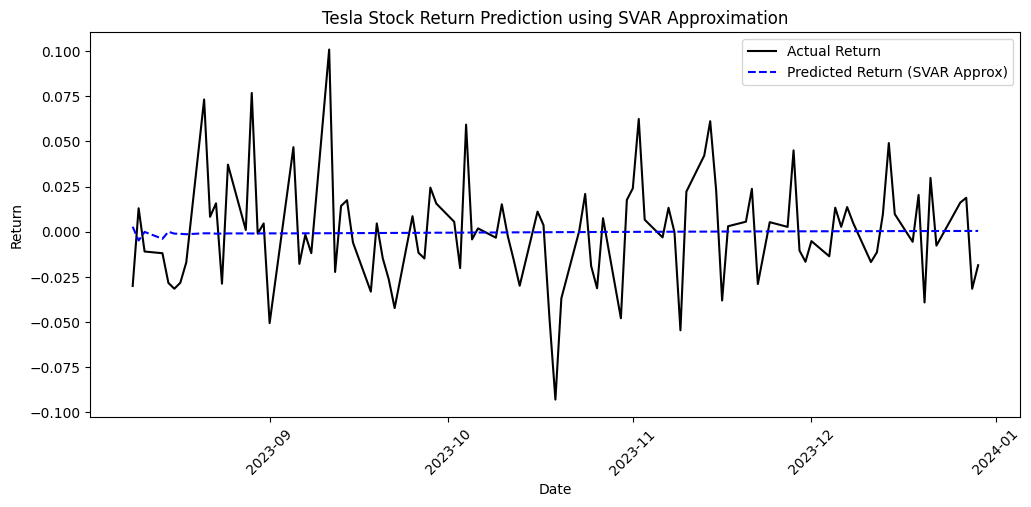

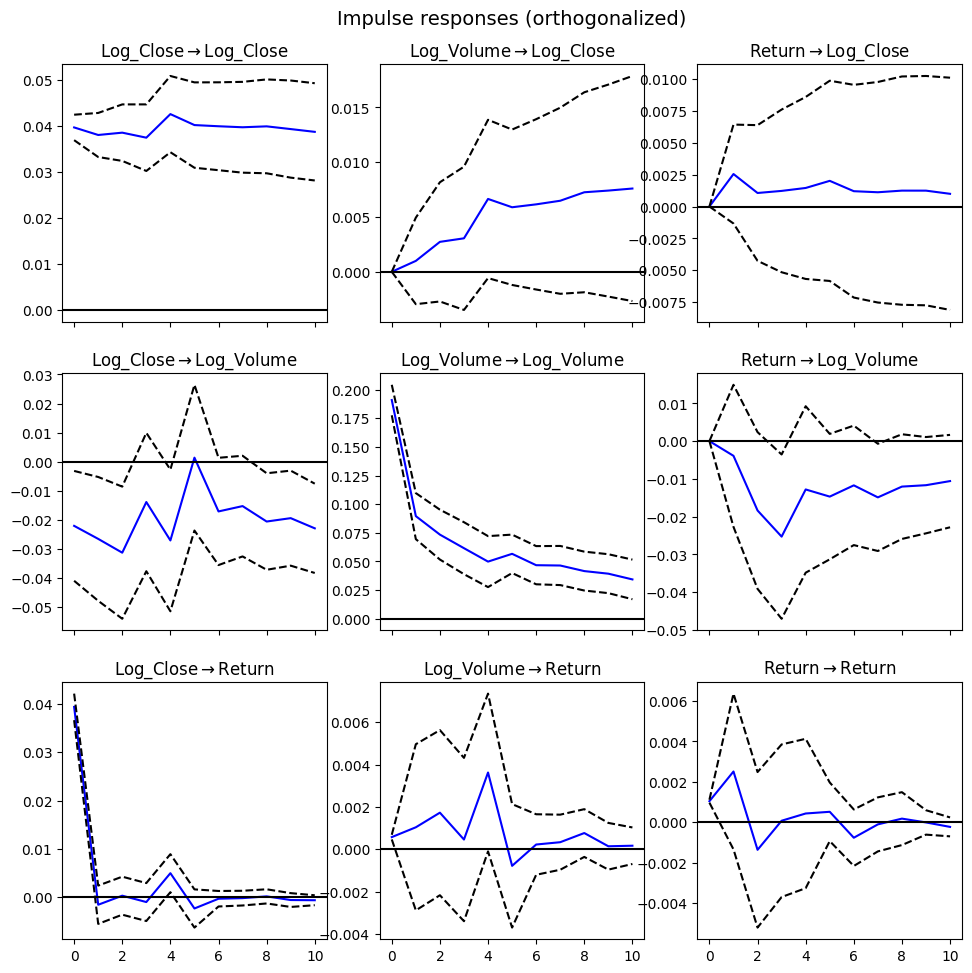

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# ✅ 2️⃣ 데이터 전처리 및 Feature 생성
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])  # 날짜 변환
df["Return"] = df["Close"].pct_change()  # 수익률 계산
df["Log_Close"] = np.log(df["Close"].replace(0, np.nan))  # 로그 변환 종가
df["Log_Volume"] = np.log(df["Volume"].replace(0, np.nan))  # 로그 변환 거래량
df = df.dropna().reset_index(drop=True)  # 결측값 제거 및 인덱스 리셋

# ✅ 3️⃣ 변수 선택 (SVAR 모델 입력 변수)
data = df[["Date", "Log_Close", "Log_Volume", "Return"]].set_index("Date")

# ✅ 4️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size].copy(), data.iloc[train_size:].copy()

# ✅ 4️⃣-1 결측치 및 무한대 값 제거
train = train.dropna()
train = train[~train.isin([np.inf, -np.inf]).any(axis=1)]
test = test.dropna()
test = test[~test.isin([np.inf, -np.inf]).any(axis=1)]

# ✅ 5️⃣ 최적의 VAR 차수(p) 선택 (AIC 기준)
lag_selection = VAR(train)
lag_results = lag_selection.select_order(maxlags=10)
best_lag = lag_results.aic  # AIC 최소값을 갖는 차수 선택
best_lag = max(best_lag, 1)  # ✅ 최소 1 이상 유지
print(f"✅ 최적의 차수 (p): {best_lag}")

# ✅ 6️⃣ VAR 모델 학습
var_model = VAR(train)
var_fit = var_model.fit(best_lag)

# ✅ 7️⃣ Cholesky 분해를 사용한 구조적 SVAR 근사
cov_matrix = var_fit.sigma_u  # 잔차 공분산 행렬
chol_decomp = np.linalg.cholesky(cov_matrix)  # Cholesky 분해 적용

# ✅ 8️⃣ 예측 수행 (테스트 데이터 크기만큼 예측)
test_pred = var_fit.forecast(train.values[-best_lag:], steps=len(test))

# ✅ 9️⃣ 예측된 결과를 데이터프레임으로 변환
test_pred_df = pd.DataFrame(test_pred, index=test.index, columns=["Log_Close_Pred", "Log_Volume_Pred", "Return_Pred"])

# ✅ 🔟 로그 변환 해제
test_pred_df["Close_Pred"] = np.exp(test_pred_df["Log_Close_Pred"])

# ✅ 11️⃣ 성능 평가 (MSE)
test_mse = mean_squared_error(np.exp(test["Log_Close"]), test_pred_df["Close_Pred"])
print(f"📌 Test MSE: {test_mse:.4f}")

# ✅ 12️⃣ 결과 시각화 (실제 vs 예측 종가)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test_pred_df.index, test_pred_df["Close_Pred"], label="Predicted (SVAR Approx)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using SVAR Approximation")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 13️⃣ 수익률 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(test_pred_df.index, test["Return"], label="Actual Return", color="black")
plt.plot(test_pred_df.index, test_pred_df["Return_Pred"], label="Predicted Return (SVAR Approx)", linestyle="--", color="blue")
plt.title("Tesla Stock Return Prediction using SVAR Approximation")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 12️⃣ Impulse Response Function (IRF) 분석 (Cholesky 기반)
irf = var_fit.irf(10)  # 10-step Impulse Response Function
irf.plot(orth=True)
plt.show()



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ 최적의 차수 (p): 5
⚠️ Warning: ValueError during model fitting at step 0: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 1: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 2: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 3: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 4: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 5: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 6: zero-size array to reduction operation maximum which has no identity
⚠️ Warning: ValueError during model fitting at step 7: zero-size array to reduction operation maximum which has no i

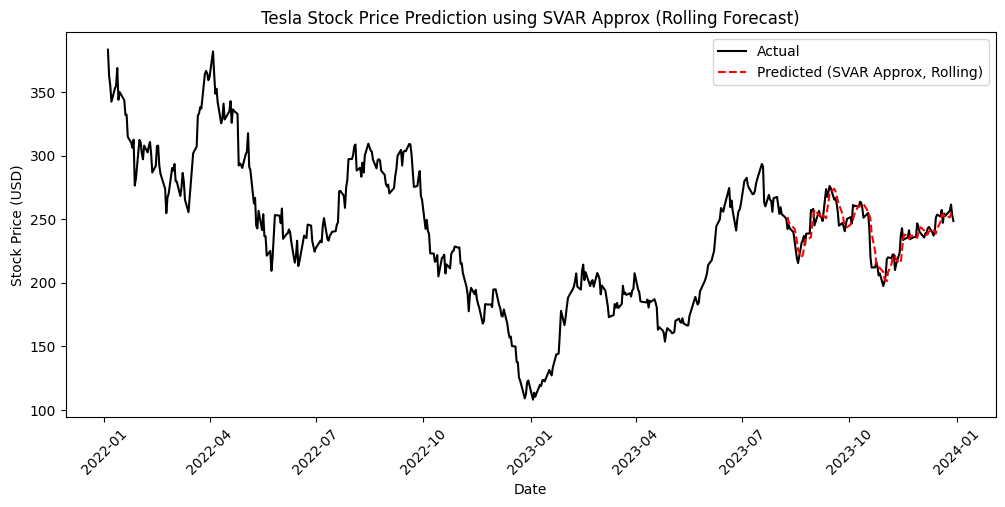

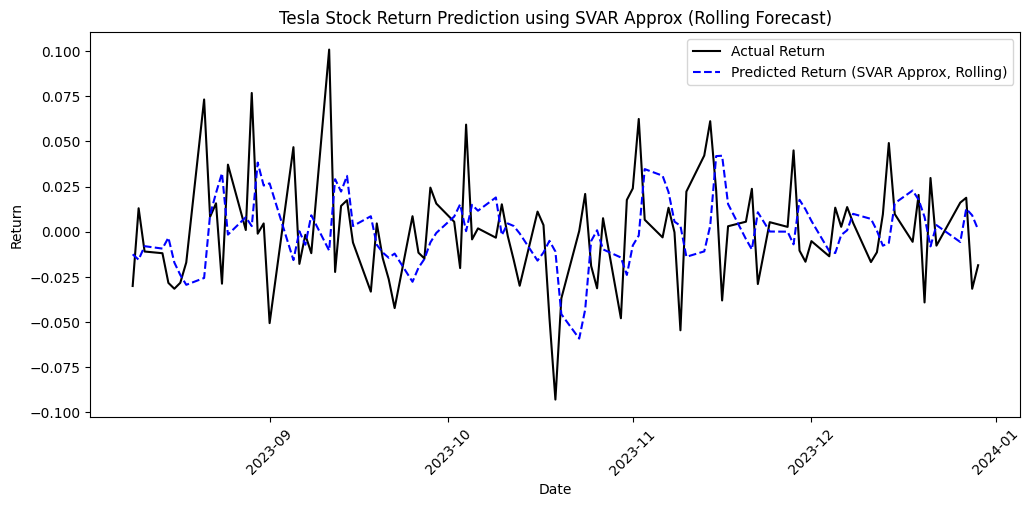

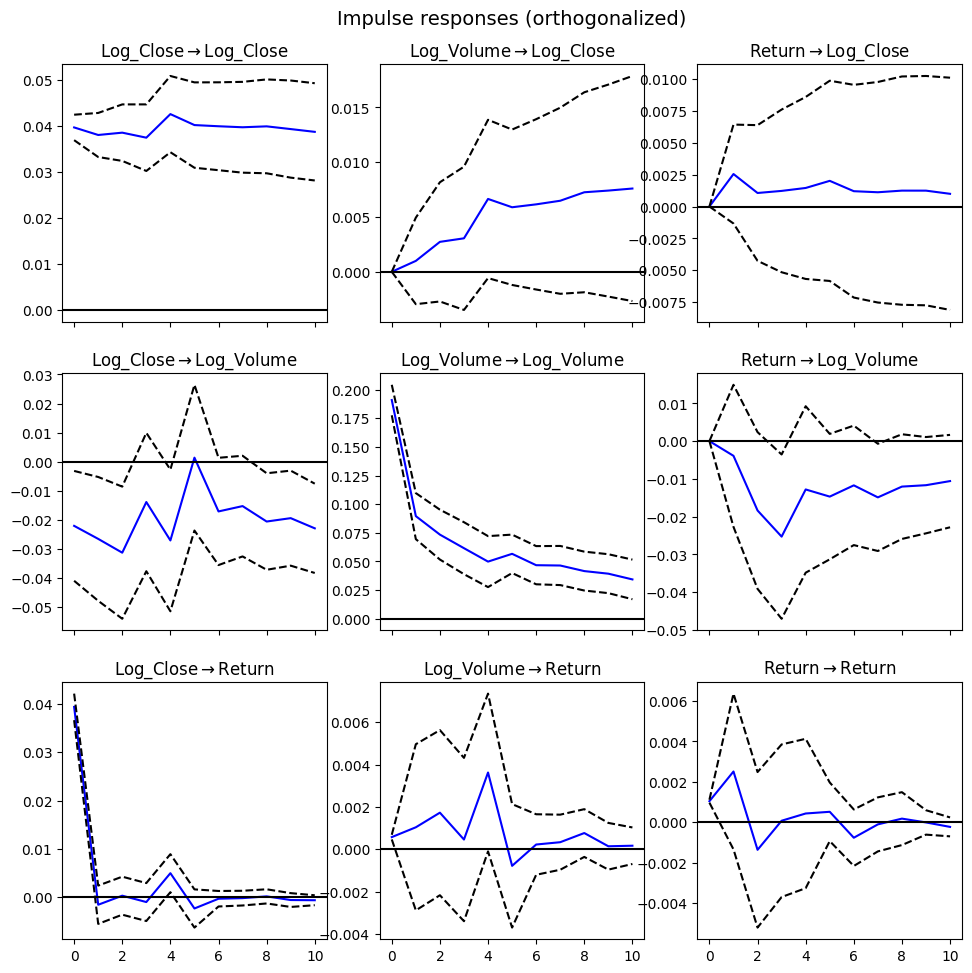

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# ✅ 2️⃣ 데이터 전처리 및 Feature 생성
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])  # 날짜 변환
df["Return"] = df["Close"].pct_change()  # 수익률 계산
df["Log_Close"] = np.log(df["Close"].replace(0, np.nan))  # 로그 변환 종가
df["Log_Volume"] = np.log(df["Volume"].replace(0, np.nan))  # 로그 변환 거래량
df = df.dropna().reset_index(drop=True)  # 결측값 제거 및 인덱스 리셋

# ✅ 3️⃣ 변수 선택 (SVAR 모델 입력 변수)
data = df[["Date", "Log_Close", "Log_Volume", "Return"]].set_index("Date")

# ✅ 4️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size].copy(), data.iloc[train_size:].copy()

# ✅ 4️⃣-1 결측치 및 무한대 값 제거
train = train.dropna()
train = train[~train.isin([np.inf, -np.inf]).any(axis=1)]
test = test.dropna()
test = test[~test.isin([np.inf, -np.inf]).any(axis=1)]

# ✅ 5️⃣ 최적의 VAR 차수(p) 선택 (AIC 기준)
lag_selection = VAR(train)
lag_results = lag_selection.select_order(maxlags=10)
best_lag = lag_results.aic  # AIC 최소값을 갖는 차수 선택
best_lag = max(best_lag, 1)  # ✅ 최소 1 이상 유지
print(f"✅ 최적의 차수 (p): {best_lag}")

# ✅ 6️⃣ SVAR을 위한 Cholesky 분해 (구조적 제약 적용)
var_model = VAR(train)
var_fit = var_model.fit(best_lag)

cov_matrix = var_fit.sigma_u  # 잔차 공분산 행렬
chol_decomp = np.linalg.cholesky(cov_matrix)  # Cholesky 분해 적용

# ✅ 7️⃣ 롤링 SVAR 예측 (One-step Rolling Forecast)
rolling_predictions = []
history = train.values.tolist()  # Use the entire train data as initial history

for t in range(len(test)):
    # Create history_df from the last 'best_lag' data points in history
    history_df = pd.DataFrame(history[-best_lag:], columns=train.columns)

    # ✅ 데이터 문제 감지 및 해결
    if len(history_df) < best_lag or history_df.empty or history_df.nunique().min() <= 1:
        print(f"⚠️ Warning: Insufficient or constant data at step {t}. Adjusting...")

        # 최근 3일치 평균으로 대체
        avg_values = np.mean(history[-3:], axis=0).tolist() if len(history) >= 3 else history[-1]
        rolling_predictions.append(avg_values)  # 최근 평균값 사용

        # 실제 데이터를 추가하여 업데이트
        history.append(test.iloc[t].values.tolist())
        continue  # Skip to the next iteration

    # ✅ 6️⃣-4 모델 학습 및 예측
    model = VAR(history_df)

    # 데이터가 모두 동일한 경우 모델 학습 방지
    if np.all(history_df.values == history_df.values[0, :], axis=0).any():
        print(f"⚠️ Warning: No variation in data at step {t}. Adjusting...")
        avg_values = np.mean(history[-3:], axis=0).tolist()
        rolling_predictions.append(avg_values)
        history.append(test.iloc[t].values.tolist())
        continue

    try:
        model_fit = model.fit(best_lag)
    except ValueError as e:
        print(f"⚠️ Warning: ValueError during model fitting at step {t}: {e}")
        avg_values = np.mean(history[-3:], axis=0).tolist()
        rolling_predictions.append(avg_values)
        history.append(test.iloc[t].values.tolist())
        continue

    # ✅ 6️⃣-5 한 스텝 예측 수행 (SVAR 적용)
    pred = model_fit.forecast(history_df.values[-best_lag:], steps=1)
    svar_pred = np.dot(chol_decomp, pred.T).T  # Cholesky 변환 적용
    rolling_predictions.append(svar_pred[0])

    # ✅ 6️⃣-6 예측값을 history에 추가하여 업데이트
    history.append(svar_pred[0].tolist())  # 예측값 추가

# ✅ 7️⃣ 예측된 결과를 데이터프레임으로 변환
rolling_predictions = np.array(rolling_predictions)
test_pred_df = pd.DataFrame(rolling_predictions, index=test.index[:len(rolling_predictions)], columns=["Log_Close_Pred", "Log_Volume_Pred", "Return_Pred"])

# ✅ 8️⃣ 로그 변환 해제
test_pred_df["Close_Pred"] = np.exp(test_pred_df["Log_Close_Pred"])

# ✅ 9️⃣ 성능 평가 (MSE)
test_mse = mean_squared_error(np.exp(test["Log_Close"][:len(test_pred_df)]), test_pred_df["Close_Pred"])
print(f"📌 Test MSE: {test_mse:.4f}")

# ✅ 10️⃣ 결과 시각화 (실제 vs 예측 종가)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test_pred_df.index, test_pred_df["Close_Pred"], label="Predicted (SVAR Approx, Rolling)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using SVAR Approx (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 11️⃣ 수익률 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(test_pred_df.index, test["Return"][:len(test_pred_df)], label="Actual Return", color="black")
plt.plot(test_pred_df.index, test_pred_df["Return_Pred"], label="Predicted Return (SVAR Approx, Rolling)", linestyle="--", color="blue")
plt.title("Tesla Stock Return Prediction using SVAR Approx (Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ✅ 12️⃣ Impulse Response Function (IRF) 분석 (Cholesky 기반)
irf = var_fit.irf(10)  # 10-step Impulse Response Function
irf.plot(orth=True)
plt.show()
